In [1]:
import sys
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
TR = 3
run_len = 480
block_len_t = 60
block_len_vol = int (block_len_t / TR)
triallist = np.array(['rest', 'up', 'rest', 'up', 'rest', 'up', 'rest', 'up'])
rest_blocks = np.array(np.where(triallist == 'rest')[0])
up_blocks = np.array(np.where(triallist == 'up')[0])

In [3]:
imagine = ['pyneal_003','pyneal_004','pyneal_006','pyneal_007']
act = ['pyneal_002']
all_runs = ['pyneal_002','pyneal_003','pyneal_004','pyneal_006','pyneal_007']
runs_dict = dict(act=['pyneal_002'],
                nfb_gm=['pyneal_003','pyneal_004'],
                nfb_supeficial=['pyneal_006'],
                nfb_deep=['pyneal_007'])
runs_description = ['act','nfb_gm1','nfb_gm2','nfb_superficial','nfb_deep']
datadir = '/data/pt_02900/analysis-highres/data/sub-57'
datafile = 'receivedFunc.feat/filtered_func_data.nii.gz'
mask_types = ['gm','superficial','deep']
mask_file = dict()
mask_file['gm'] =  '/data/pt_02900/analysis-highres/data/sub-57/proc/roi_gm_slab.nii'
mask_file['superficial'] = '/data/pt_02900/analysis-highres/data/sub-57/proc/roi_layer2_slab.nii'
mask_file['deep'] = '/data/pt_02900/analysis-highres/data/sub-57/proc/roi_layer1_slab.nii'

In [4]:
mask_data = {i: nib.load(mask_file[i]).get_fdata() for i in mask_types}

In [5]:
baseline_offset_vols = 6 

In [6]:
rest_indexes = [(i*20 - baseline_offset_vols,i*20 + block_len_vol) for i in rest_blocks[1:]]
rest_indexes

[(34, 60), (74, 100), (114, 140)]

In [7]:
up_indexes = [(i*20 - baseline_offset_vols,i*20 + block_len_vol) for i in up_blocks]
up_indexes

[(14, 40), (54, 80), (94, 120), (134, 160)]

In [8]:
def get_ERPS(block_indexes):
    runs_analysis = dict()
    for key,val in runs_dict.items():
        print(f'Processing Run: {key} Pyneal folders: {val}')
        erp_list = []
        #collate all the blocks
        for pyneal_folder in val:
            tmp_data = nib.load(os.path.join(datadir,pyneal_folder,datafile)).get_fdata()
            erp_list.extend([tmp_data[:,:,:,idx[0]:idx[1]] for idx in block_indexes])
        print(f'Total {len(erp_list)} blocks')
        #stack all blocks into a (4D,#blocks) ndarray
        all_erp = np.stack(erp_list,-1)
        #get average activation in RoI for each blocks
        roi_erps = {i: np.mean(all_erp[mask_data[i] > 0],axis=0) for i in mask_types}
        #get average activation in baseline volumes for each block
        roi_baseline = {i: np.mean(roi_erps[i][0:6,:],axis=0) for i in mask_types}
        #get %change over baseline average at all volumes for each block
        pct_chg = {i: roi_erps[i]/roi_baseline[i] - 1 for i in mask_types}
        #average the %change for all the blocks
        avg_pct_chg = {i: np.mean(pct_chg[i],axis=-1) for i in mask_types}
        #prep the dict to store and return the %change ERP
        runs_analysis[key] = avg_pct_chg
    print("Finished")
    return runs_analysis

In [9]:
erp_results = dict()
for i in ['rest','up']:
    if i == 'rest':
        print("Rest blocks")
        erp_results[i] = get_ERPS(rest_indexes)
    else:
        print("Up blocks")
        erp_results[i] = get_ERPS(up_indexes)
        
        

Rest blocks
Processing Run: act Pyneal folders: ['pyneal_002']
Total 3 blocks
Processing Run: nfb_gm Pyneal folders: ['pyneal_003', 'pyneal_004']
Total 6 blocks
Processing Run: nfb_supeficial Pyneal folders: ['pyneal_006']
Total 3 blocks
Processing Run: nfb_deep Pyneal folders: ['pyneal_007']
Total 3 blocks
Finished
Up blocks
Processing Run: act Pyneal folders: ['pyneal_002']
Total 4 blocks
Processing Run: nfb_gm Pyneal folders: ['pyneal_003', 'pyneal_004']
Total 8 blocks
Processing Run: nfb_supeficial Pyneal folders: ['pyneal_006']
Total 4 blocks
Processing Run: nfb_deep Pyneal folders: ['pyneal_007']
Total 4 blocks
Finished


In [ ]:
#Plot
fig, ax = plt.subplots(nrows=len(runs_dict),ncols=1,figsize=(8,16),sharey=True)
xvals = np.arange(block_len_vol + baseline_offset_vols) - baseline_offset_vols

for block_typ,block_erps in erp_results.items():
    idx = 0
    for key,val in block_erps.items():
        for i in mask_types:
            ax[idx].plot(xvals,val[i] * 100,label=f'{block_typ} {i}'.title())
            ax[idx].axvline(0,color='gray')
            #ax[idx].axvspan(-1 * baseline_offset_vols, 0, facecolor='gray', alpha=0.2)
            ax[idx].set_title(key.title())
            ax[idx].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
            ax[idx].legend(loc='best')
            ax[idx].set_xlabel('Volumes')
            ax[idx].set_ylabel('fMRI signal(%change from baseline)')
            
        idx += 1
#handles, labels = ax[-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()   
plt.savefig('fig_erp.png', dpi=300)

In [12]:
def get_ERPS_method2(block_indexes):
    runs_analysis = dict()
    for key,val in runs_dict.items():
        print(f'Processing Run: {key} Pyneal folders: {val}')
        erp_list = []
        for pyneal_folder in val:
            tmp_data = nib.load(os.path.join(datadir,pyneal_folder,datafile)).get_fdata()
            erp_list.extend([tmp_data[:,:,:,idx[0]:idx[1]] for idx in block_indexes])
        print(f'Total {len(erp_list)} blocks')
        tmp_erp = np.stack(erp_list,-1)
        tmp_baseline_avg = np.mean(tmp_erp[:,:,:,0:baseline_offset_vols,:],axis=3)
        with np.errstate(divide='warn', invalid='ignore'):
            tmp_percent_chng = tmp_erp / tmp_baseline_avg[:,:,:,None,:] - 1 
            tmp_percent_chng[ tmp_percent_chng == np.inf] = 0
            tmp_percent_chng = np.nan_to_num(tmp_percent_chng)
        avg_percent_change =  np.mean(tmp_percent_chng,axis=-1)
        mask_avg = {i: np.average(avg_percent_change[mask_data[i] > 0],axis=0) for i in mask_types}
        runs_analysis[key] = mask_avg
    print("Finished")
    return runs_analysis

In [13]:
erp_results_2 = dict()
for i in ['rest','up']:
    if i == 'rest':
        print("Rest blocks")
        erp_results_2[i] = get_ERPS(rest_indexes)
    else:
        print("Up blocks")
        erp_results_2[i] = get_ERPS(up_indexes)

Rest blocks
Processing Run: act Pyneal folders: ['pyneal_002']
Total 3 blocks
Processing Run: nfb_gm Pyneal folders: ['pyneal_003', 'pyneal_004']
Total 6 blocks
Processing Run: nfb_superior Pyneal folders: ['pyneal_006']
Total 3 blocks
Processing Run: nfb_deep Pyneal folders: ['pyneal_007']
Total 3 blocks
Finished
Up blocks
Processing Run: act Pyneal folders: ['pyneal_002']
Total 4 blocks
Processing Run: nfb_gm Pyneal folders: ['pyneal_003', 'pyneal_004']
Total 8 blocks
Processing Run: nfb_superior Pyneal folders: ['pyneal_006']
Total 4 blocks
Processing Run: nfb_deep Pyneal folders: ['pyneal_007']
Total 4 blocks
Finished


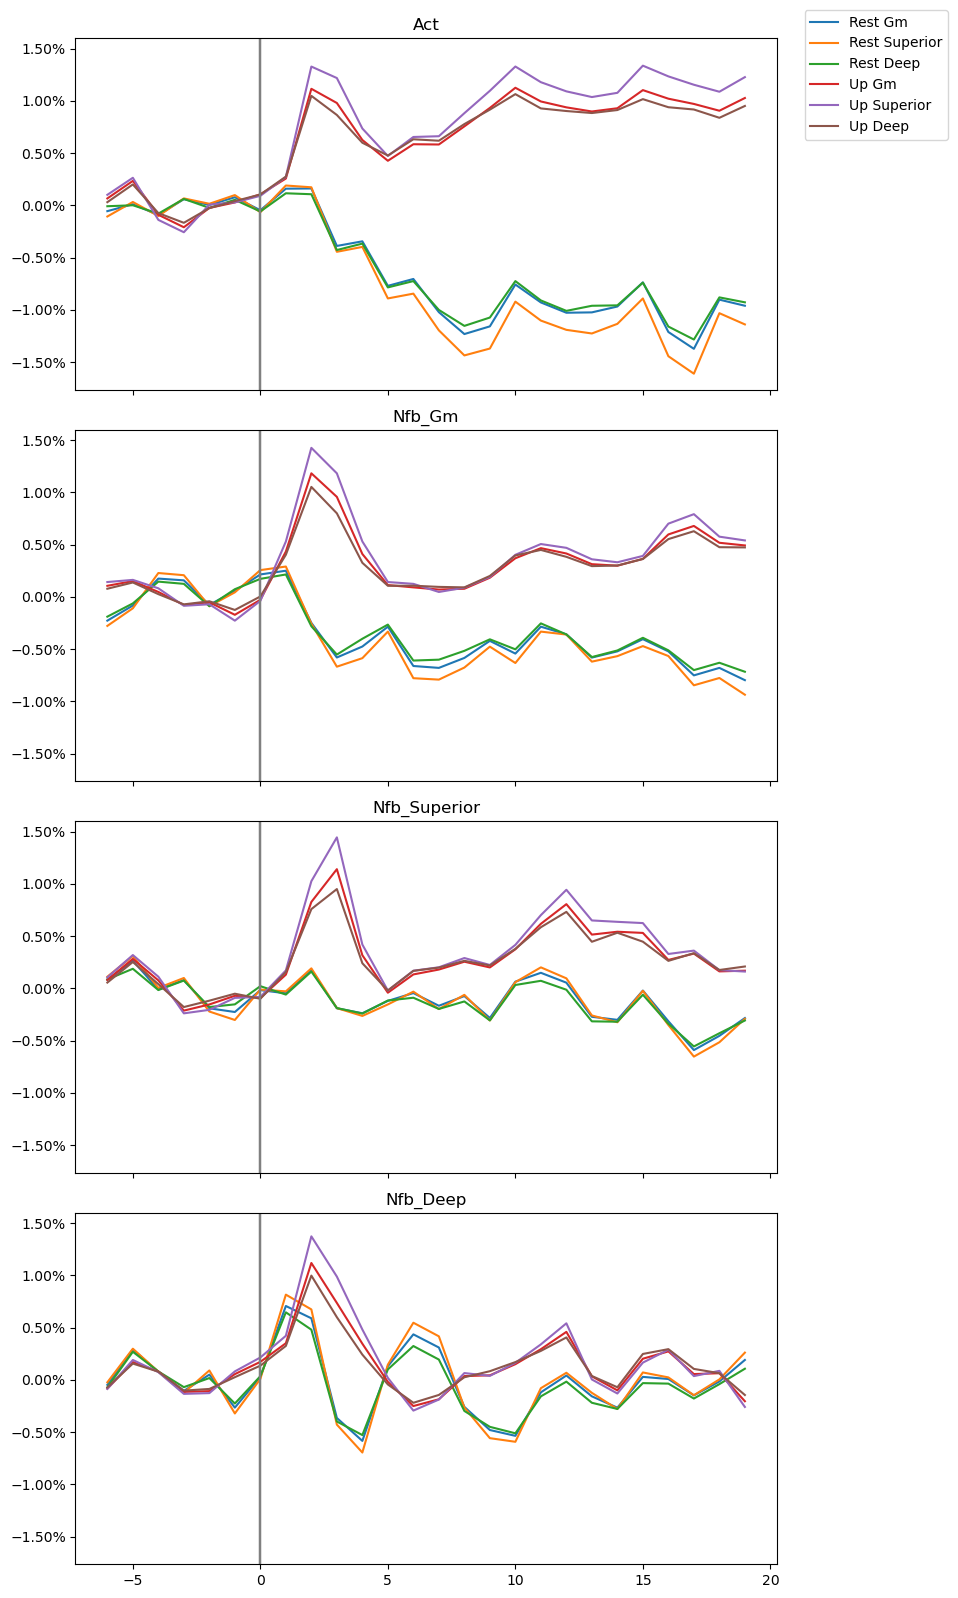

In [14]:
#Plot
fig, ax = plt.subplots(nrows=len(runs_dict),ncols=1,figsize=(8,16),sharex=True,sharey=True)
xvals = np.arange(block_len_vol + baseline_offset_vols) - baseline_offset_vols

for block_typ,block_erps in erp_results_2.items():
    idx = 0
    for key,val in block_erps.items():
        for i in mask_types:
            ax[idx].plot(xvals,val[i] * 100,label=f'{block_typ} {i}'.title())
            ax[idx].axvline(0,color='gray')
            #ax[idx].axvspan(-1 * baseline_offset_vols, 0, facecolor='gray', alpha=0.2)
            ax[idx].set_title(key.title())
            ax[idx].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
            ax[idx].legend(loc='best')
        idx += 1
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()

# Processing times

In [168]:
import re
pattern_1 = re.compile('volIdx:\d+ total_proc_time:')
pattern_2 = re.compile(' total_proc_time:')
pattern_3 = re.compile('scanReceiver: received volIdx \d+')
pattern_4 = re.compile('pynealPreprocessing: started volIdx \d+')
pattern_5 = re.compile('pynealPreprocessing: preprocessed volIdx \d+')
pattern_6 = re.compile('resultsServer: volIdx \d+')
l_time = len('2024-04-02 14:11:43.730')
l_1 = len('volIdx:')
l_2 = len(' total_proc_time:')
l_3 = len('scanReceiver: received volIdx ')
l_4 = len('pynealPreprocessing: started volIdx ')
l_5 = len('pynealPreprocessing: preprocessed volIdx ')
l_6 = len('resultsServer: volIdx ')

In [153]:
import datetime
from dateutil import parser
format_strng = '%Y-%m-%d %H:%M:%S.%s'
#datetime_str = datetime.datetime.strptime(date_time, format) 

In [138]:
t1 = parser.parse('2024-04-02 14:11:43.730')
t2 = parser.parse('2024-04-02 14:11:46.750')

In [139]:
t2 - t1

datetime.timedelta(seconds=3, microseconds=20000)

In [136]:
t1

datetime.datetime(2024, 4, 2, 14, 11, 46, 750000)

In [137]:
t2

datetime.datetime(2024, 4, 2, 14, 11, 46, 750000)

In [206]:
all_results = []
for run_id,run_dir in enumerate(all_runs):
    datasrc = os.path.join(datadir,run_dir,'pynealLog.log')
    print(f'gathering from {datasrc}')
    proc_t = [0.0] * 160
    recv_scan = ['na'] * 160
    preproc_start = ['na'] * 160
    preproc_end = ['na'] * 160
    result_end = ['na'] * 160
    with open(datasrc) as f:
        line = f.readline()
        while line:
            res1 = re.search(pattern_1,line)
            res_3 = re.search(pattern_3,line)
            res_4 = re.search(pattern_4,line)
            res_5 = re.search(pattern_5,line)
            res_6 = re.search(pattern_6,line)
            #print(res_3,res_4,res_5,res_6)
            if res1:
                res2 = re.search(pattern_2,line)
                vid = int(line[res1.start() + l_1 :res2.start()])
                ptime = float(line[res2.start() + l_2 :])
                proc_t[vid] = ptime
            if res_3:
                vid = int(res_3.group()[l_3:])
                recv_scan[vid] = pd.Timestamp(line[:l_time])
            if res_4:
                vid = int(res_4.group()[l_4:])
                preproc_start[vid] = pd.Timestamp(line[:l_time])
            if res_5:
                vid = int(res_5.group()[l_5:])
                preproc_end[vid] = pd.Timestamp(line[:l_time])
            if res_6:
                vid = int(res_6.group()[l_6:])
                result_end[vid] = pd.Timestamp(line[:l_time])          
            line = f.readline()
    for idx in np.arange(160):
        all_results.append(dict(run_id=run_id,
                           run_desc=runs_description[run_id],
                           vol_id=idx,
                           proc_time=proc_t[idx],
                           recv_scan=recv_scan[idx],
                           preproc_start=preproc_start[idx],
                           preproc_end=preproc_end[idx],
                           result_end=result_end[idx],
                          ))  
        
      

gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_002/pynealLog.log
gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_003/pynealLog.log
gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_004/pynealLog.log
gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_006/pynealLog.log
gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_007/pynealLog.log


In [207]:
results_df = pd.DataFrame(all_results)
results_df

,run_id,run_desc,vol_id,proc_time,recv_scan,preproc_start,preproc_end,result_end
0,0,act,0,0.301816,2024-04-02 14:11:40.945,2024-04-02 14:11:41.012,2024-04-02 14:11:41.313000,2024-04-02 14:11:41.313
1,0,act,1,0.309870,2024-04-02 14:11:43.360,2024-04-02 14:11:43.420,2024-04-02 14:11:43.730000,2024-04-02 14:11:43.730
2,0,act,2,4.592272,2024-04-02 14:11:46.449,2024-04-02 14:11:46.536,na,2024-04-02 14:11:51.128
3,0,act,3,2.304430,2024-04-02 14:11:49.472,2024-04-02 14:11:51.278,2024-04-02 14:11:53.492000,2024-04-02 14:11:53.582
4,0,act,4,2.013524,2024-04-02 14:11:52.431,2024-04-02 14:11:53.895,2024-04-02 14:11:55.807000,2024-04-02 14:11:55.908
...,...,...,...,...,...,...,...,...
795,4,nfb_deep,155,1.805452,2024-04-02 15:21:42.884,2024-04-02 15:21:44.613,2024-04-02 15:21:46.318000,2024-04-02 15:21:46.419
796,4,nfb_deep,156,1.810284,2024-04-02 15:21:48.579,2024-04-02 15:21:48.623,2024-04-02 15:21:50.335000,2024-04-02 15:21:50.433
797,4,nfb_deep,157,1.900132,2024-04-02 15:21:48.895,2024-04-02 15:21:50.537,2024-04-02 15:21:52.344000,2024-04-02 15:21:52.437
798,4,nfb_deep,158,2.014068,2024-04-02 15:21:54.590,2024-04-02 15:21:54.650,2024-04-02 15:21:56.567000,2024-04-02 15:21:56.664


In [208]:
results_df['recv_to_preproc_start'] = (results_df['preproc_start'] - results_df['recv_scan']).dt.total_seconds()
results_df['recv_to_result'] = (results_df['result_end'] - results_df['recv_scan']).dt.total_seconds()
results_df['calculated_proc_time'] = results_df['recv_to_result'] - results_df['recv_to_preproc_start']
results_df


,run_id,run_desc,vol_id,proc_time,recv_scan,preproc_start,preproc_end,result_end,recv_to_preproc_start,recv_to_result,calculated_proc_time
0,0,act,0,0.301816,2024-04-02 14:11:40.945,2024-04-02 14:11:41.012,2024-04-02 14:11:41.313000,2024-04-02 14:11:41.313,0.067,0.368,0.301
1,0,act,1,0.309870,2024-04-02 14:11:43.360,2024-04-02 14:11:43.420,2024-04-02 14:11:43.730000,2024-04-02 14:11:43.730,0.060,0.370,0.310
2,0,act,2,4.592272,2024-04-02 14:11:46.449,2024-04-02 14:11:46.536,na,2024-04-02 14:11:51.128,0.087,4.679,4.592
3,0,act,3,2.304430,2024-04-02 14:11:49.472,2024-04-02 14:11:51.278,2024-04-02 14:11:53.492000,2024-04-02 14:11:53.582,1.806,4.110,2.304
4,0,act,4,2.013524,2024-04-02 14:11:52.431,2024-04-02 14:11:53.895,2024-04-02 14:11:55.807000,2024-04-02 14:11:55.908,1.464,3.477,2.013
...,...,...,...,...,...,...,...,...,...,...,...
795,4,nfb_deep,155,1.805452,2024-04-02 15:21:42.884,2024-04-02 15:21:44.613,2024-04-02 15:21:46.318000,2024-04-02 15:21:46.419,1.729,3.535,1.806
796,4,nfb_deep,156,1.810284,2024-04-02 15:21:48.579,2024-04-02 15:21:48.623,2024-04-02 15:21:50.335000,2024-04-02 15:21:50.433,0.044,1.854,1.810
797,4,nfb_deep,157,1.900132,2024-04-02 15:21:48.895,2024-04-02 15:21:50.537,2024-04-02 15:21:52.344000,2024-04-02 15:21:52.437,1.642,3.542,1.900
798,4,nfb_deep,158,2.014068,2024-04-02 15:21:54.590,2024-04-02 15:21:54.650,2024-04-02 15:21:56.567000,2024-04-02 15:21:56.664,0.060,2.074,2.014


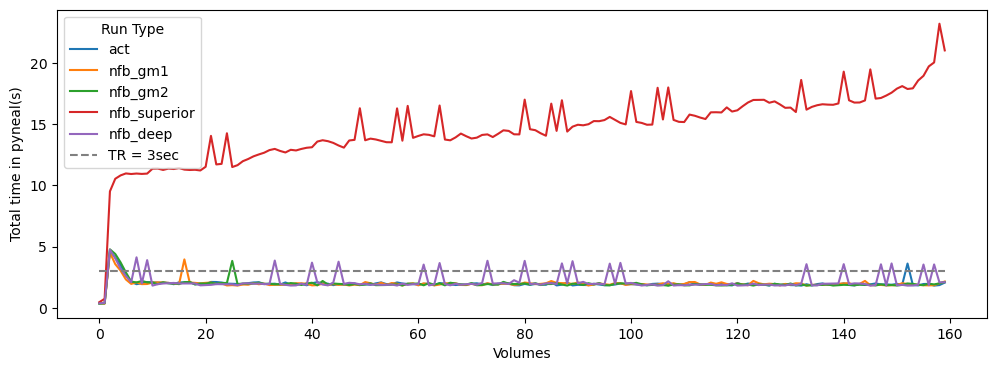

In [227]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax = sns.lineplot(x="vol_id", y="recv_to_result",
             hue="run_desc",
             data=results_df)
#ax.axhline(3,color='gray',label='TR')
ax.plot(np.arange(160),np.full(160,3),color='gray',linestyle='--',label='TR = 3sec')
ax.set_ylabel("Total time in pyneal(s)")
ax.set_xlabel("Volumes")
plt.legend(title = 'Run Type')
plt.savefig('total_time.png',dpi=300)
plt.show()

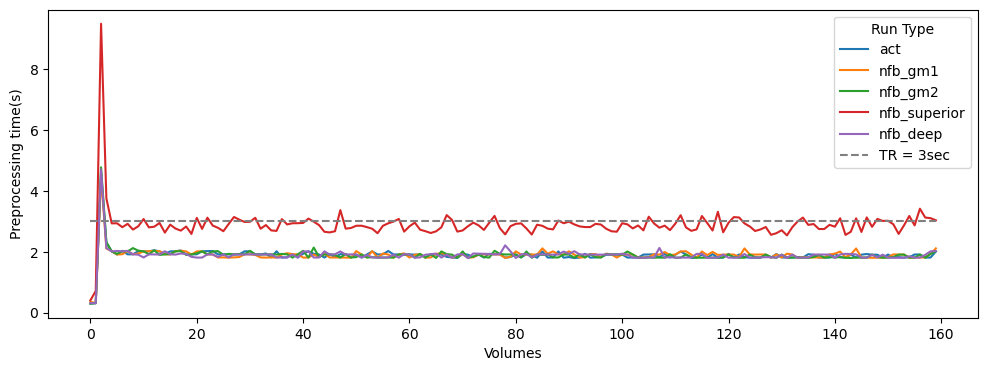

In [224]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax = sns.lineplot(x="vol_id", y="calculated_proc_time",
             hue="run_desc",
             data=results_df)
#ax.axhline(3,color='gray',label='TR')
ax.plot(np.arange(160),np.full(160,3),color='gray',linestyle='--',label='TR = 3sec')
ax.set_ylabel("Preprocessing time(s)")
ax.set_xlabel("Volumes")
plt.legend(title = 'Run Type')
plt.savefig('preproc_time.png',dpi=300)
plt.show()

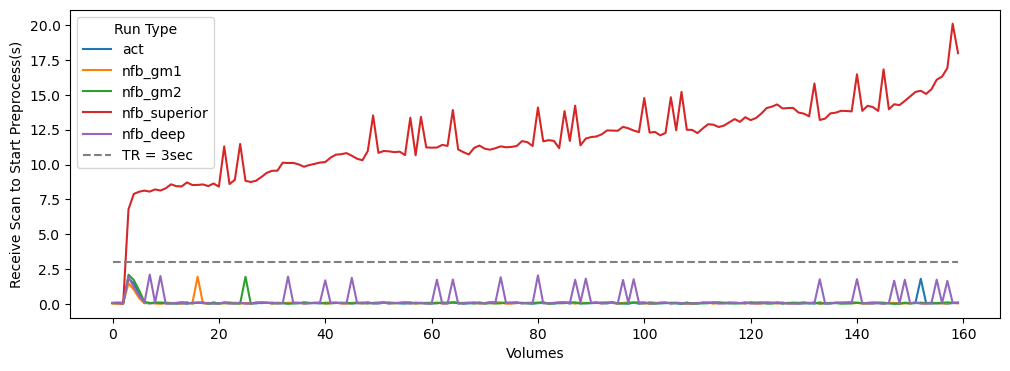

In [226]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax = sns.lineplot(x="vol_id", y="recv_to_preproc_start",
             hue="run_desc",
             data=results_df)
#ax.axhline(3,color='gray',label='TR')
ax.plot(np.arange(160),np.full(160,3),color='gray',linestyle='--',label='TR = 3sec')
ax.set_ylabel("Receive Scan to Start Preprocess(s)")
ax.set_xlabel("Volumes")
plt.legend(title = 'Run Type')
plt.savefig('recv_preprocess.png',dpi=300)
plt.show()

In [142]:
result = []
vol_idx = [f'volIdx {i}' for i in np.arange(160)]
for run_id,run_dir in enumerate(all_runs):
    datasrc = os.path.join(datadir,run_dir,'pynealLog.log')
    print(f'gathering from {datasrc}')
    with open(datasrc) as f:
        line = f.readline()
        while line:
            res1 = re.search(pattern_1,line)
            if res1:
                res2 = re.search(pattern_2,line)
                vid = int(line[res1.start() + l_1 :res2.start()])
                ptime = float(line[res2.start() + l_2 :])
                result.append(dict(run_id=run_id,run_desc=runs_description[run_id],vol_id=vid,proc_time=ptime))
            line = f.readline()
            

gathering from /data/pt_02900/analysis-highres/data/sub-57/pyneal_002/pynealLog.log
0:00:02.785000
0:00:00.370000
-1 day, 23:59:57.281000
-1 day, 23:59:54.258000
-1 day, 23:59:51.299000
-1 day, 23:59:48.262000
-1 day, 23:59:45.389000
-1 day, 23:59:42.401000
-1 day, 23:59:39.356000
-1 day, 23:59:36.332000
-1 day, 23:59:33.299000
-1 day, 23:59:30.257000
-1 day, 23:59:27.394000
-1 day, 23:59:24.397000
-1 day, 23:59:21.360000
-1 day, 23:59:18.309000
-1 day, 23:59:15.277000
-1 day, 23:59:12.252000
-1 day, 23:59:09.387000
-1 day, 23:59:06.389000
-1 day, 23:59:03.342000
-1 day, 23:59:00.312000
-1 day, 23:58:57.277000
-1 day, 23:58:54.411000
-1 day, 23:58:51.411000
-1 day, 23:58:48.369000
-1 day, 23:58:45.342000
-1 day, 23:58:42.309000
-1 day, 23:58:39.265000
-1 day, 23:58:36.403000
-1 day, 23:58:33.400000
-1 day, 23:58:30.356000
-1 day, 23:58:27.326000
-1 day, 23:58:24.292000
-1 day, 23:58:21.231000
-1 day, 23:58:18.383000
-1 day, 23:58:15.383000
-1 day, 23:58:12.346000
-1 day, 23:58:09.30600

In [46]:
ptime_df = pd.DataFrame(result)

In [48]:
ptime_df

,run_id,run_desc,vol_id,proc_time
0,0,act,0,0.301816
1,0,act,1,0.309870
2,0,act,2,4.592272
3,0,act,3,2.304430
4,0,act,4,2.013524
...,...,...,...,...
795,4,nfb_deep,155,1.805452
796,4,nfb_deep,156,1.810284
797,4,nfb_deep,157,1.900132
798,4,nfb_deep,158,2.014068


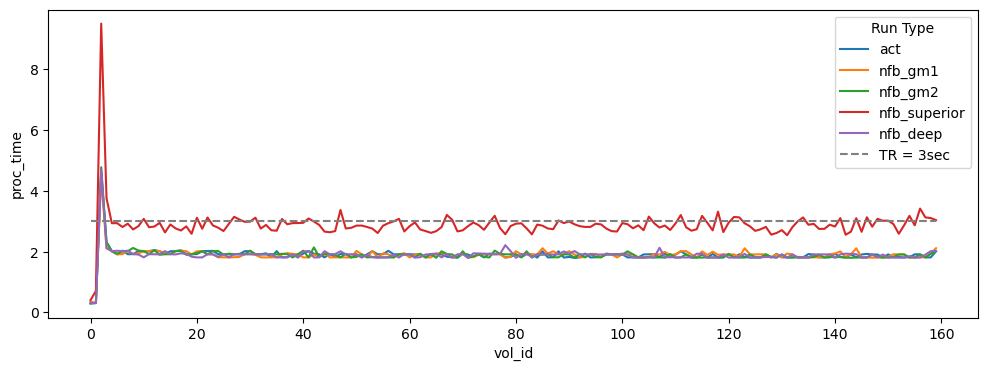

In [62]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax = sns.lineplot(x="vol_id", y="proc_time",
             hue="run_desc",
             data=ptime_df)
#ax.axhline(3,color='gray',label='TR')
ax.plot(np.arange(160),np.full(160,3),color='gray',linestyle='--',label='TR = 3sec')
plt.legend(title = 'Run Type')
plt.savefig('proctimes.png',dpi=300)

In [64]:
file = "/data/pt_02900/analysis-highres/data/psychopydata/sub-57_2024-04-02_15h12.26.981_session_001.csv"

In [65]:
d = pd.read_csv(file)
d

,runs.thisRepN,runs.thisTrialN,runs.thisN,runs.thisIndex,volumes.thisRepN,volumes.thisTrialN,volumes.thisN,volumes.thisIndex,sync_mri_key.keys,sync_mri_key.started,...,expName,psychopyVersion,baseline,volumes,TR,n_vols_up,n_vols_down,start_block,frameRate,Unnamed: 512
0,0,0,0,0,NaN,NaN,NaN,NaN,t,21.944877,...,NFB,2022.1.4,949.54,160,3.0,20,20,down,59.997397,NaN


In [72]:
vol_start_t = [i for i in d.columns if 'start.vol.' in i]
vol_res_t = [i for i in d.columns if 'result.t.vol.' in i]

In [81]:
start_times = d[vol_start_t].T.reset_index().rename(columns={"index": "vol_id", 0: "start_t"})
result_times = d[vol_res_t].T.reset_index().rename(columns={"index": "vol_id", 0: "result_t"})

In [88]:
start_times['vol_id'] = start_times['vol_id'].str.lstrip('start.vol.')
result_times['vol_id'] = result_times['vol_id'].str.lstrip('result.t.vol.')

In [113]:
combined_df = pd.merge(start_times,result_times, on='vol_id', how='inner')

In [114]:
combined_df['proc_t'] = combined_df['result_t'] - combined_df['start_t'] - 3
combined_df['ist'] = combined_df['start_t'].diff()
combined_df['t_diff_res'] = combined_df['result_t'].diff()

In [115]:
combined_df

,vol_id,start_t,result_t,proc_t,ist,t_diff_res
0,0,102.578834,110.578336,4.999502,NaN,NaN
1,1,105.712115,112.994451,4.282335,3.133281,2.416114
2,2,108.711818,120.344561,8.632743,2.999702,7.350110
3,3,111.645376,122.661287,8.015911,2.933559,2.316726
4,4,114.662190,124.677679,7.015489,3.016814,2.016392
...,...,...,...,...,...,...
155,155,568.349867,575.932731,4.582864,2.049846,1.916449
156,156,571.999460,579.949474,4.950014,3.649592,4.016743
157,157,573.916385,581.949113,5.032728,1.916926,1.999639
158,158,577.783089,585.464449,4.681360,3.866704,3.515336


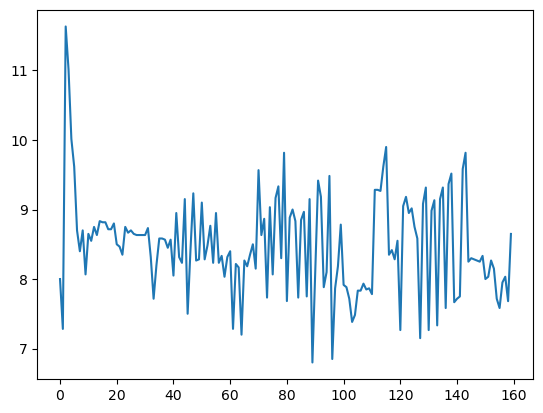

In [112]:
plt.plot(combined_df['total_t'])

## Old test code

In [ ]:
#mask data
mask_data = {i: nib.load(mask_file[i]).get_fdata() for i in mask_types}

In [ ]:
[(i*20,i*20 + 2* block_len_vol -1) for i in rest_blocks]

##Whole rest-up block##

In [ ]:
data = nib.load(os.path.join(datadir,act[0],datafile)).get_fdata()
blocks = [data[:,:,:,i*20:i*20 + 2* block_len_vol] for i in rest_blocks]
erps = np.stack(blocks,-1)
avg = {i: np.average(erps[mask_data[i] > 0],axis=0) for i in mask_types}
baseline = {i: np.average(avg[i][14:20,:],axis=0) for i in mask_types}
percent_chng = {i: (avg[i] - baseline[i])/baseline[i] for i in mask_types}

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
xs = np.arange(40) - 20
for i in mask_types:
    ax[0].plot(xs,np.average(avg[i],axis=1),label=i)
    ax[0].set_title('fMRI response(Amplitude)')
    ax[0].axvline(0,color='gray')
    ax[0].axvspan(-6, 0, facecolor='gray', alpha=0.2)
    ax[1].plot(xs,np.average(percent_chng[i],axis=1),label=i)
    ax[1].set_title('fMRI response(%Change)')
    ax[1].axvline(0,color='gray')
    ax[1].axvspan(-6, 0, facecolor='gray', alpha=0.2)
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()

In [ ]:
#for imagine runs

In [ ]:
runs = dict(gm=['pyneal_003','pyneal_004'],superficial=['pyneal_006'],inferior=['pyneal_007'])

In [ ]:

runs_analysis = []
for key in all_runs:
    tmp_data = nib.load(os.path.join(datadir,key,datafile)).get_fdata()
    tmp_blocks = [tmp_data[:,:,:,i*20:i*20 + 2* block_len_vol] for i in rest_blocks]
    tmp_erps = np.stack(tmp_blocks,-1)
    tmp_avg = {i: np.average(tmp_erps[mask_data[i] > 0],axis=0) for i in mask_types}
    tmp_baseline = {i: np.average(tmp_avg[i][14:20,:],axis=0) for i in mask_types}
    tmp_percent_chng = {i: (tmp_avg[i] - tmp_baseline[i])/tmp_baseline[i] for i in mask_types}
    runs_analysis.append(tmp_percent_chng)

In [ ]:
#comparison across runs
fig, ax = plt.subplots(nrows=len(runs_analysis),ncols=1,figsize=(8,12),sharex=True,sharey=True)
xvals = np.arange(40) - 20
for idx,val in enumerate(runs_analysis):
    for i in mask_types:
        ax[idx].plot(xvals,np.average(val[i],axis=1),label=i)
        ax[idx].axvline(0,color='gray')
        ax[idx].axvspan(-6, 0, facecolor='gray', alpha=0.2)
        ax[idx].set_title(runs_description[idx].title())
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()   

In [ ]:
from matplotlib import cm
ylorbr = cm.get_cmap('viridis', len(runs_description))
x = ylorbr(np.linspace(0,1,len(runs_description)))

In [ ]:
#comparison across layers for the runs
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(8,12),sharex=True,sharey=True)
xvals = np.arange(40) - 20
for idx,m_val in enumerate(mask_types):
    for i,run_typ in enumerate(runs_description):
        ax[idx].plot(xvals,np.average(runs_analysis[i][m_val],axis=1),color=x[i],label=run_typ)
        ax[idx].axvline(0,color='gray')
        ax[idx].axvspan(-6, 0, facecolor='gray', alpha=0.2)
        ax[idx].set_title(m_val.title())
        ax[idx].legend(loc='best')
#handles, labels = ax[-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
#fig.legend(handles, labels, loc='upper right',bbox_to_anchor=(1.05, 1.0))
plt.tight_layout()   

##only up block with baseline

In [ ]:
niftifile = nib.load(os.path.join(datadir,act[0],datafile))

In [ ]:
data = niftifile.get_fdata()
niftifile.shape

In [ ]:
#cut into pieces
baseline_offset_vols = 6 
end_offset_vols =  6 
start_idx = [i * block_len_vol - baseline_offset_vols for i in up_blocks]
#end_idx = [(i + 1) * block_len_vol + end_offset_vols for i in up_blocks]
end_idx = [(i + 1) * block_len_vol for i in up_blocks]

In [ ]:
blocks = [data[:,:,:,start_idx[i]:start_idx[i] + baseline_offset_vols + block_len_vol ] for i in range(len(start_idx))]

In [ ]:
erps = np.stack(blocks,-1)

In [ ]:
mask = nib.load(mask_gm).get_fdata()

In [ ]:
average_roi_signal = np.average(erps[mask > 0],axis=0)

In [ ]:
baseline_average = np.average(average_roi_signal[:5,:],axis=0)
baseline_average.shape

In [ ]:
percent_chng = (average_roi_signal - baseline_average)/baseline_average

In [ ]:
percent_chng.shape

In [ ]:
plt.plot(np.average(average_roi_signal,axis=1))

In [ ]:
plt.plot(np.average(percent_chng,axis=1))

In [ ]:
plt.plot(percent_chng)

In [ ]:
#seeing rest and up together
blocks2 = [data[:,:,:,i*20:i*20 + 2* block_len_vol -1] for i in rest_blocks]
erps2 = np.stack(blocks2,-1)
average_roi_signal2 = np.average(erps2[mask > 0],axis=0)
baseline_average2 = np.average(average_roi_signal2[6:14,:],axis=0)
percent_chng2 = (average_roi_signal2 - baseline_average2)/baseline_average2

In [ ]:
[(i*20, i*20 + 2* block_len_vol -1 ) for i in rest_blocks]

In [ ]:
plt.plot(percent_chng2)

In [ ]:
plt.plot(np.average(percent_chng2,axis=1))

In [ ]:
plt.plot(np.average(average_roi_signal2,axis=1))

In [ ]:
plt.plot(average_roi_signal2)